# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

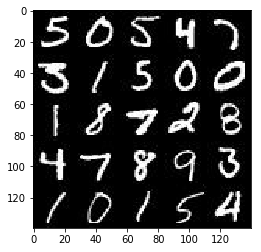

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

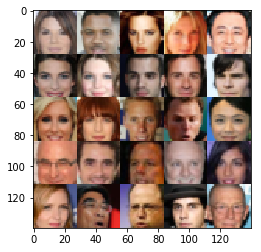

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # image layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # l4*14*64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7*7*128
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True,alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out=tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
class GAN:
    def __init__(self, data_shape, z_dim, learning_rate, beta1=0.5):
        
        self.input_real, self.input_z,self.learning_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, data_shape[3])
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,print_every=10,show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    net=GAN(data_shape,z_dim,learning_rate, beta1=beta1)
    saver = tf.train.Saver()
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for steps,batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: (batch_images*2.0), net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_real: (batch_images*2.0), net.input_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: (batch_images*2)})
                    train_loss_g = net.g_loss.eval({net.input_real: (batch_images*2.0), net.input_z: batch_z})
 
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
            
                if steps % show_every == 0:
                    show_generator_output(sess=sess,
                                          image_mode=data_image_mode,
                                          input_z=net.input_z,
                                         n_images=10,
                                             out_channel_dim=data_shape[3])
    #plot losses
    fig,ax=pyplot.subplots()
    losses=np.array(losses)
    pyplot.plot(losses.T[0],label='Discriminator')
    pyplot.plot(losses.T[1],label='Generator')
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.5308


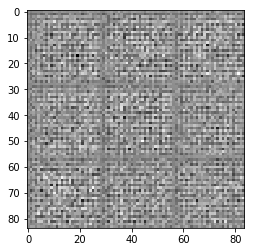

Epoch 1/2... Discriminator Loss: 0.3447... Generator Loss: 1.5241
Epoch 1/2... Discriminator Loss: 0.3368... Generator Loss: 1.6181
Epoch 1/2... Discriminator Loss: 0.4332... Generator Loss: 1.4449
Epoch 1/2... Discriminator Loss: 0.2801... Generator Loss: 1.8923
Epoch 1/2... Discriminator Loss: 0.2197... Generator Loss: 2.2731
Epoch 1/2... Discriminator Loss: 0.2309... Generator Loss: 2.4359
Epoch 1/2... Discriminator Loss: 0.1598... Generator Loss: 2.4132
Epoch 1/2... Discriminator Loss: 0.1613... Generator Loss: 2.5937
Epoch 1/2... Discriminator Loss: 0.3234... Generator Loss: 2.8345
Epoch 1/2... Discriminator Loss: 0.2762... Generator Loss: 2.3127


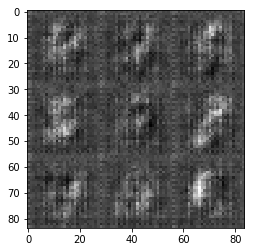

Epoch 1/2... Discriminator Loss: 0.3249... Generator Loss: 1.8297
Epoch 1/2... Discriminator Loss: 0.3795... Generator Loss: 1.5617
Epoch 1/2... Discriminator Loss: 0.9286... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 1.1783
Epoch 1/2... Discriminator Loss: 0.4417... Generator Loss: 1.8149
Epoch 1/2... Discriminator Loss: 1.8486... Generator Loss: 0.2084
Epoch 1/2... Discriminator Loss: 0.5270... Generator Loss: 2.1684
Epoch 1/2... Discriminator Loss: 0.5172... Generator Loss: 1.3250
Epoch 1/2... Discriminator Loss: 0.6072... Generator Loss: 2.4545
Epoch 1/2... Discriminator Loss: 0.5004... Generator Loss: 2.1114


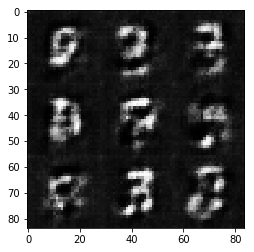

Epoch 1/2... Discriminator Loss: 0.4726... Generator Loss: 1.9423
Epoch 1/2... Discriminator Loss: 0.5287... Generator Loss: 1.2635
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 1.7883
Epoch 1/2... Discriminator Loss: 0.5802... Generator Loss: 2.0328
Epoch 1/2... Discriminator Loss: 0.5398... Generator Loss: 1.7908
Epoch 1/2... Discriminator Loss: 0.6052... Generator Loss: 1.1971
Epoch 1/2... Discriminator Loss: 0.5456... Generator Loss: 1.4487
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 2.7273
Epoch 1/2... Discriminator Loss: 0.5189... Generator Loss: 1.7290
Epoch 1/2... Discriminator Loss: 0.6016... Generator Loss: 1.4536


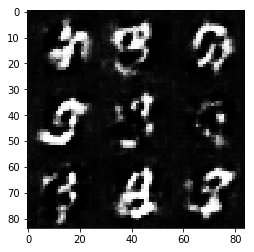

Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 0.5492... Generator Loss: 1.4397
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 2.2490
Epoch 1/2... Discriminator Loss: 0.6862... Generator Loss: 2.2162
Epoch 1/2... Discriminator Loss: 0.6130... Generator Loss: 1.1347
Epoch 1/2... Discriminator Loss: 0.5843... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 0.9976... Generator Loss: 0.6045
Epoch 1/2... Discriminator Loss: 0.5649... Generator Loss: 1.4547
Epoch 1/2... Discriminator Loss: 0.5755... Generator Loss: 1.7368
Epoch 1/2... Discriminator Loss: 0.6042... Generator Loss: 1.7853


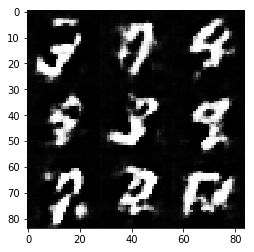

Epoch 1/2... Discriminator Loss: 0.5541... Generator Loss: 1.3828
Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 1.2465
Epoch 1/2... Discriminator Loss: 0.5673... Generator Loss: 1.5358
Epoch 1/2... Discriminator Loss: 0.5968... Generator Loss: 1.9511
Epoch 1/2... Discriminator Loss: 0.6360... Generator Loss: 1.0012
Epoch 1/2... Discriminator Loss: 0.5749... Generator Loss: 1.4261
Epoch 2/2... Discriminator Loss: 0.5538... Generator Loss: 1.6810


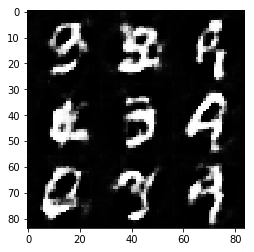

Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 1.5020
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 0.8509
Epoch 2/2... Discriminator Loss: 0.6104... Generator Loss: 1.1776
Epoch 2/2... Discriminator Loss: 0.5814... Generator Loss: 1.6125
Epoch 2/2... Discriminator Loss: 0.5907... Generator Loss: 1.6832
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 0.4796
Epoch 2/2... Discriminator Loss: 0.5776... Generator Loss: 1.4346
Epoch 2/2... Discriminator Loss: 0.5500... Generator Loss: 1.4511
Epoch 2/2... Discriminator Loss: 0.5638... Generator Loss: 1.5377
Epoch 2/2... Discriminator Loss: 0.6354... Generator Loss: 2.0165


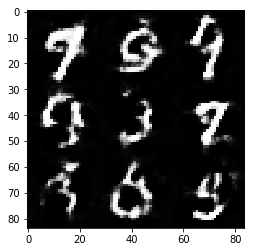

Epoch 2/2... Discriminator Loss: 0.5350... Generator Loss: 1.5144
Epoch 2/2... Discriminator Loss: 0.5905... Generator Loss: 1.7600
Epoch 2/2... Discriminator Loss: 0.5986... Generator Loss: 1.4477
Epoch 2/2... Discriminator Loss: 0.6166... Generator Loss: 1.6957
Epoch 2/2... Discriminator Loss: 0.8045... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 2.0833
Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 1.2316
Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 1.0385
Epoch 2/2... Discriminator Loss: 0.6584... Generator Loss: 1.7731
Epoch 2/2... Discriminator Loss: 0.7944... Generator Loss: 0.8446


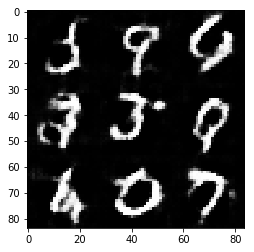

Epoch 2/2... Discriminator Loss: 0.6629... Generator Loss: 2.0599
Epoch 2/2... Discriminator Loss: 0.7354... Generator Loss: 1.8118
Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 0.6475... Generator Loss: 1.3502
Epoch 2/2... Discriminator Loss: 0.8996... Generator Loss: 0.7486
Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 1.5167
Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.3764
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 0.7663
Epoch 2/2... Discriminator Loss: 0.6666... Generator Loss: 1.7221
Epoch 2/2... Discriminator Loss: 0.6875... Generator Loss: 1.5555


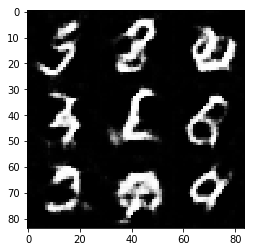

Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 0.7435
Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 1.0077
Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 1.9720
Epoch 2/2... Discriminator Loss: 0.9976... Generator Loss: 2.5072
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 0.8629
Epoch 2/2... Discriminator Loss: 0.7095... Generator Loss: 1.1499
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.4646
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 0.6600
Epoch 2/2... Discriminator Loss: 0.7209... Generator Loss: 1.7178
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 1.0361


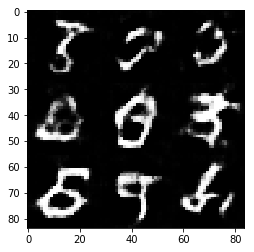

Epoch 2/2... Discriminator Loss: 0.8222... Generator Loss: 1.5475
Epoch 2/2... Discriminator Loss: 0.8060... Generator Loss: 0.8545
Epoch 2/2... Discriminator Loss: 0.7618... Generator Loss: 1.1849
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 1.1315
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 1.8297
Epoch 2/2... Discriminator Loss: 0.7242... Generator Loss: 1.2019


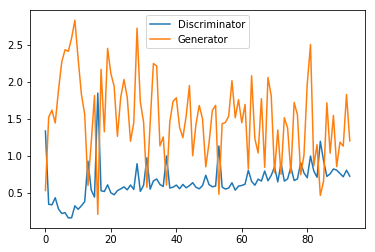

In [20]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7553... Generator Loss: 0.2910


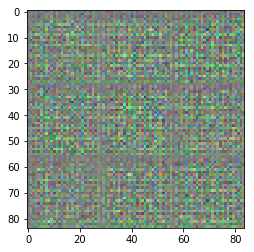

Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 1.7908
Epoch 1/1... Discriminator Loss: 0.3264... Generator Loss: 1.7774
Epoch 1/1... Discriminator Loss: 0.2463... Generator Loss: 2.1920
Epoch 1/1... Discriminator Loss: 0.2093... Generator Loss: 2.3205
Epoch 1/1... Discriminator Loss: 0.2193... Generator Loss: 2.5008
Epoch 1/1... Discriminator Loss: 0.3034... Generator Loss: 3.8300
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 0.6457... Generator Loss: 1.1149


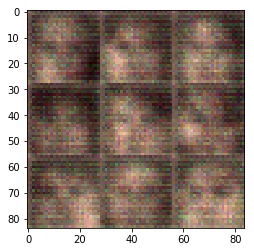

Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 1.5836
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 1.6350
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.7954
Epoch 1/1... Discriminator Loss: 0.5502... Generator Loss: 1.7380
Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 1.4846
Epoch 1/1... Discriminator Loss: 0.5857... Generator Loss: 1.6123
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 1.3607
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 1.3230
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 1.8565
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.9115


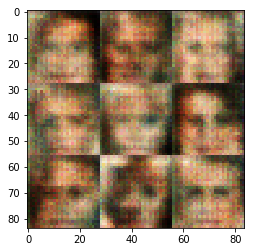

Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 2.8322
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.8643
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.9985
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.5474


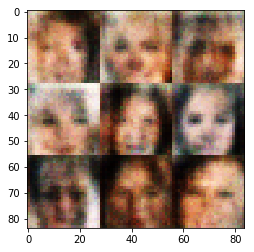

Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 1.2876
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.7277
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 1.4453
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 2.2788
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 1.8702


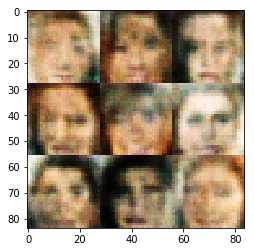

Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.7031
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.4311
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.7503
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.5927
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.3231
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 3.1491


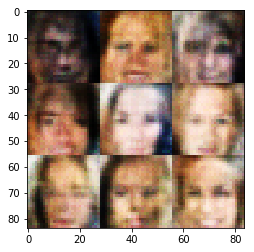

Epoch 1/1... Discriminator Loss: 0.6531... Generator Loss: 1.3695
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.3804
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.3098
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.3650
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 1.2897
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.2332


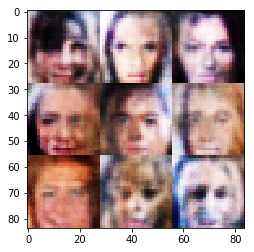

Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.5680
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.4957
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.2860
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.2833
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.0038


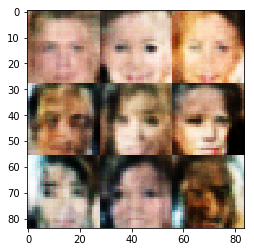

Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.3734
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.1175


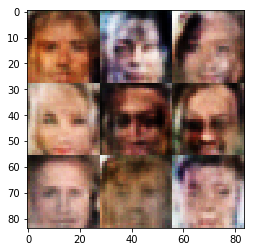

Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.4965
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.2815
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 0.9946


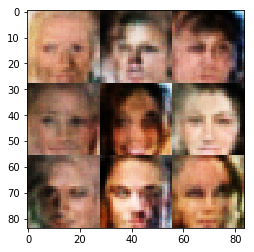

Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.5621
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.2674
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.4169
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.5648


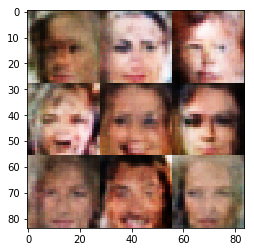

Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.8609
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.1850


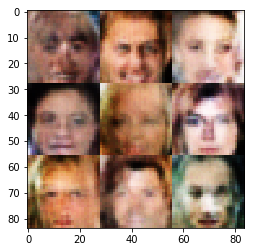

Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.2091
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.6898


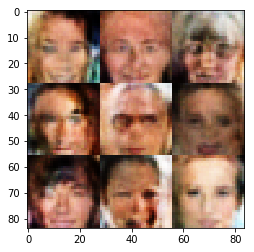

Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.6823


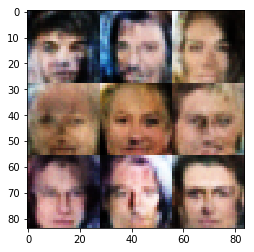

Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.0486


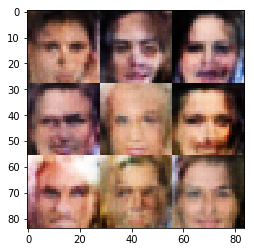

Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.8073


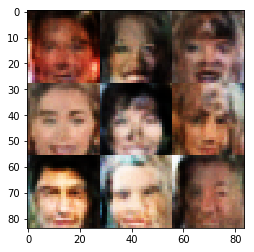

Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 1.3815
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.8891


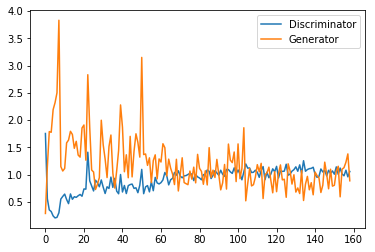

In [21]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.